# clone + import + drive + paths


In [1]:
!git clone https://github.com/danielroich/Face-Identity-Disentanglement-via-StyleGan2.git 'project'

fatal: destination path 'project' already exists and is not an empty directory.


In [2]:
!pip install pytorch-msssim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content')
CODE_DIR = 'project'
os.chdir(f'./{CODE_DIR}')

In [5]:
from Losses.AdversarialLoss import calc_Dw_loss
from Models.Encoders.ID_Encoder import resnet50_scratch_dag
from Models.Encoders.Attribute_Encoder import Encoder_Attribute
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Losses.NonAdversarialLoss import id_loss,landmark_loss,rec_loss
from Models.StyleGan2.model import Generator
from Utils.data_utils import plot_single_w_image, get_w_by_index, WDataSet, ConcatDataset, make_concat_loaders, cycle_images_to_create_diff_order
from Training.trainer import Trainer
import torch
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
sns.set()

In [6]:
BASE_PATH = '/content/drive/MyDrive/CNN-project-weights/'

RETINA_WEIGHTS_PATH = BASE_PATH + 'mobilenet0.25_Final.pth'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'stylegan2-ffhq-config-f.pt'
E_ID_WEIGHTS_PATH = BASE_PATH + 'resnet50_scratch_dag.pth'
IMAGE_DATA_DIR = BASE_PATH + 'fake/image/'
W_DATA_DIR = BASE_PATH + 'fake/w/'

# network + data


In [7]:
id_encoder = resnet50_scratch_dag(E_ID_WEIGHTS_PATH).cuda()
attr_encoder = Encoder_Attribute().cuda()
discriminator = Discriminator(512).cuda()
mlp = LatentMapper(4096).cuda()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH, RETINA_WEIGHTS_PATH)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [8]:
generator = Generator(1024,512,8).cuda()
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)
generator = generator.train()

In [9]:
id_encoder = id_encoder.train()
attr_encoder = attr_encoder.train()
discriminator = discriminator.train()
mlp = mlp.train()

In [10]:
id_transform=transforms.Compose([
                                transforms.Resize(id_encoder.meta['imageSize'][1]),
                                transforms.CenterCrop(id_encoder.meta['imageSize'][1]),
                                transforms.Normalize(np.asarray(id_encoder.meta['mean']) / 255, np.asarray(id_encoder.meta['std']) / 255)
                                ])

attr_transform=transforms.Compose([
                                transforms.Resize(attr_encoder.meta['imageSize'][1]),
                                transforms.CenterCrop(attr_encoder.meta['imageSize'][1]),
                                transforms.Normalize(np.asarray(attr_encoder.meta['mean']), np.asarray(attr_encoder.meta['std']))
                                ])

landmark_transform=transforms.Compose([transforms.Resize(256)])

In [11]:
data_dir = IMAGE_DATA_DIR

attr_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
id_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
w_dataset = WDataSet(W_DATA_DIR)

In [12]:
config = {
    'beta1' : 0.5,
    'beta2' : 0.999,
    'lrD' : 0.0002,
    'lrMLP' : 0.00004,
    'lrAttr' : 0.0001,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 4,
    'R1Param' : 10,
    'lambdaID' : 5,
    'lambdaLND' : 0.5,
    'lambdaREC' : 1,
    'a' : 0.84
}

In [13]:
train_loader = make_concat_loaders(config['batchSize'],(id_dataset, attr_dataset,w_dataset))

#Training

In [14]:
discriminator = Discriminator(512).cuda()
mlp = LatentMapper(4096).cuda()
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=config['lrD'], betas=(config['beta1'], config['beta2']))
optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=config['lrMLP'], betas=(config['beta1'], config['beta2']))

In [15]:
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=config['lrD'], betas=(config['beta1'], config['beta2']))
optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=config['lrMLP'], betas=(config['beta1'], config['beta2']))

In [16]:
MLP_losses = []
D_real_losses = []
D_fake_losses = []
MLP_preds = []
D_real_preds = []
D_fake_preds = []

In [17]:
trainer = Trainer(config, optimizerD,optimizerMLP,discriminator,generator,
                  id_transform, attr_transform,landmark_transform, id_encoder, attr_encoder, landmark_encoder)

In [21]:
id_images, attr_images, ws = next(iter((train_loader)))

torch.cuda.empty_cache()
id_images = id_images[0].cuda()
attr_images = attr_images[0].cuda()
cycled_attr_images = cycle_images_to_create_diff_order(attr_images).clone()
non_cycled_attr_images = attr_images.clone()
ws = ws.cuda()

with torch.no_grad():
  id_vec = torch.squeeze(id_encoder(id_transform(id_images)))
  non_cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(non_cycled_attr_images)))
  cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(cycled_attr_images)))
  non_cycled_test_vec = torch.cat((id_vec,non_cycled_attr_vec), dim=1)
  cycled_test_vec = torch.cat((id_vec,cycled_attr_vec), dim=1)

For index 0 in test_vec we have the following input:
ID image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


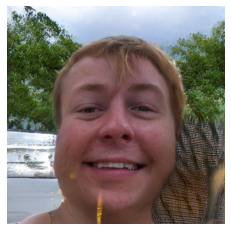

Attr image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


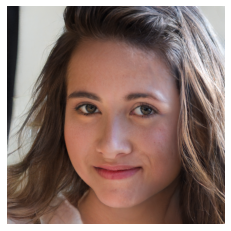

In [22]:
print('For index 0 in test_vec we have the following input:')

print('ID image:')
plot_single_w_image(ws[0], generator)

print('Attr image:')
plot_single_w_image(ws[config['batchSize'] - 1], generator)

## Batch overfitting


 error_real: 0.6981146931648254, error_fake: 1.1508010625839233 
 prediction_real: 0.5090273022651672, prediction_fake: 0.6459457874298096

 g_error: 0.9653623104095459, g_pred: 0.4040168523788452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


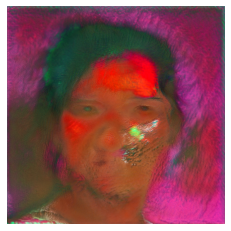

NO faces or more than one face is detected!
'NoneType' object is not iterable
id_loss_val: 4.0842132568359375
landmark_loss: 0
rec_loss: 0.7293304800987244

 error_real: 0.6389753222465515, error_fake: 3.6454460620880127 
 prediction_real: 0.5380793809890747, prediction_fake: 0.9551059007644653

 g_error: 0.12217488884925842, g_pred: 0.8873074650764465
NO faces or more than one face is detected!
'NoneType' object is not iterable
id_loss_val: 3.8269569873809814
landmark_loss: 0
rec_loss: 0

 error_real: 0.595840573310852, error_fake: 3.284299850463867 
 prediction_real: 0.5608898401260376, prediction_fake: 0.942426323890686

 g_error: 0.16740930080413818, g_pred: 0.8493455052375793
NO faces or more than one face is detected!
'NoneType' object is not iterable
id_loss_val: 3.8583641052246094
landmark_loss: 0
rec_loss: 22.189542770385742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


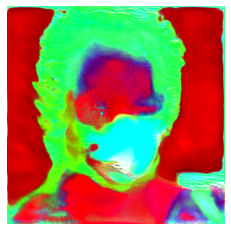


 error_real: 0.5614671111106873, error_fake: 2.5527281761169434 
 prediction_real: 0.5801799297332764, prediction_fake: 0.9104316234588623

 g_error: 0.27106595039367676, g_pred: 0.7650141716003418
NO faces or more than one face is detected!
'NoneType' object is not iterable
id_loss_val: 3.756866216659546
landmark_loss: 0
rec_loss: 3.9549927711486816

 error_real: 0.5317245125770569, error_fake: 1.5389041900634766 
 prediction_real: 0.597507655620575, prediction_fake: 0.7780436277389526

 g_error: 0.6804620027542114, g_pred: 0.5082684755325317
NO faces or more than one face is detected!
'NoneType' object is not iterable
id_loss_val: 4.077061653137207
landmark_loss: 0
rec_loss: 0

 error_real: 0.5070405602455139, error_fake: 1.006833791732788 
 prediction_real: 0.6124138236045837, prediction_fake: 0.6280195713043213

 g_error: 1.1304012537002563, g_pred: 0.33795279264450073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


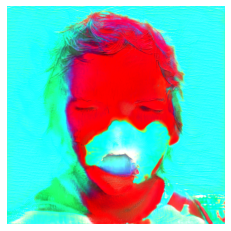

In [ ]:
same_images = True
for idx in range(10000):

  if idx % config['IdDiffersAttrTrainRatio'] == 0:
    attr_images = cycled_attr_images
    cur_vec = cycled_test_vec
    same_images = False
  else:
    attr_images = non_cycled_attr_images
    cur_vec = non_cycled_test_vec
    same_images = True

  fake_data = mlp(cur_vec)

  if idx % 2 == 0:
    trainer.adversarial_train_step(ws, fake_data)

  else:

    generated_images, _ = generator(
        [fake_data], input_is_latent=True, return_latents=False
    )
    generated_images = (generated_images + 1) / 2

    id_generated_images = id_transform(generated_images)
    # attr_generated_images = attr_transform(generated_images)

    pred_id_embedding = torch.squeeze(id_encoder(id_generated_images))
    id_loss_val = config['lambdaID'] * id_loss(id_vec, pred_id_embedding)

    lanmkmark_attr_images = landmark_transform(attr_images).permute(0,2,3,1).cpu().numpy() * 255
    lanmkmark_generated_images = landmark_transform(generated_images.detach()).permute(0,2,3,1).cpu().numpy() * 255

    try:
      _, generated_landmarks = landmark_encoder(lanmkmark_generated_images)
      _, real_landmarks = landmark_encoder(lanmkmark_attr_images)
      landmark_loss_val = config['lambdaLND'] * landmark_loss(generated_landmarks, real_landmarks)

    except Exception as e:
      print(str(e))
      landmark_loss_val = 0
    # landmark_loss_val = 0

    if idx % config['IdDiffersAttrTrainRatio'] != 0:
        rec_loss_val = config['lambdaREC'] * rec_loss(attr_images, generated_images, config['a'])
    else:
        rec_loss_val = 0

    total_error = rec_loss_val + id_loss_val + landmark_loss_val

    optimizerMLP.zero_grad()
    total_error.backward()
    optimizerMLP.step()

    print(f"id_loss_val: {id_loss_val}")
    print(f"landmark_loss: {landmark_loss_val}")
    print(f"rec_loss: {rec_loss_val}")

    

  # MLP_losses.append(g_error)
  # D_real_losses.append(error_real)
  # D_fake_losses.append(error_fake)
  # MLP_preds.append(g_pred)
  # D_fake_preds.append(prediction_fake)
  # D_real_preds.append(prediction_real)


  if idx % 5 == 0:
      with torch.no_grad():
        plot_single_w_image(mlp(cycled_test_vec)[0], generator)



## Global Training

In [ ]:
epochs = 4
same_images = True
for epoch in range(epochs):
  for idx, data in enumerate(train_loader):

    id_images, attr_images, ws = data

    id_images = id_images[0].cuda()
    attr_images = attr_images[0].cuda()
    ws = ws.cuda()

    if idx % config['IdDiffersAttrTrainRatio'] == 0:
      attr_images = cycle_images_to_create_diff_order(attr_images)
      same_images = False
    else:
      same_images = True
    
    with torch.no_grad():
      id_vec = id_encoder(id_transform(id_images))
      attr_vec = attr_encoder(attr_transform(attr_images))
      id_vec = torch.squeeze(id_vec)
      attr_vec = torch.squeeze(attr_vec)
      encoded_vec = torch.cat((id_vec,attr_vec), dim=1)

    fake_data = mlp(encoded_vec)

    if idx % 2 == 0:
      trainer.discriminator_train_step(ws, fake_data)

    else:

      optimizerMLP.zero_grad()

      generated_images, _ = generator(
          [fake_data], input_is_latent=True, return_latents=False
      )
      generated_images = (generated_images + 1) / 2

      id_generated_images = id_transform(generated_images)
      # attr_generated_images = attr_transform(generated_images)

      pred_id_embedding = torch.squeeze(id_encoder(id_generated_images))
      id_loss_val = config['lambdaID'] * id_loss(id_vec, pred_id_embedding)

      lanmkmark_attr_images = landmark_transform(attr_images).permute(0,2,3,1).cpu().numpy() * 255
      lanmkmark_generated_images = landmark_transform(generated_images.detach()).permute(0,2,3,1).cpu().numpy() * 255

      try:
        _, generated_landmarks = landmark_encoder(lanmkmark_generated_images)
        _, real_landmarks = landmark_encoder(lanmkmark_attr_images)
        landmark_loss_val = config['lambdaLND'] * landmark_loss(generated_landmarks, real_landmarks)

      except Exception as e:
        print(str(e))
        landmark_loss_val = 0


      if idx % config['IdDiffersAttrTrainRatio'] != 0:
          rec_loss_val = config['lambdaREC'] * rec_loss(attr_images, generated_images, config['a'])
      else:
          rec_loss_val = 0

      total_error = rec_loss_val + id_loss_val + landmark_loss_val

      total_error.backward()
      optimizerMLP.step()

      print(f"id_loss_val: {id_loss_val}")
      print(f"landmark_loss: {landmark_loss_val}")
      print(f"rec_loss: {rec_loss_val}")

      

    # MLP_losses.append(g_error)
    # D_real_losses.append(error_real)
    # D_fake_losses.append(error_fake)
    # MLP_preds.append(g_pred)
    # D_fake_preds.append(prediction_fake)
    # D_real_preds.append(prediction_real)


    if idx % 5 == 0:
        with torch.no_grad():
          plot_single_w_image(mlp(test_vec)[0], generator)



In [ ]:
plt.figure(figsize=(10,5))
plt.title("Mapper and Discriminator mean prob During Training")
plt.plot(MLP_preds,label="Mapper")
plt.plot(D_real_preds,label="D_real")
plt.plot(D_fake_preds,label="D_fake")
plt.xlabel("iterations")
plt.ylabel("prob")
plt.legend()
plt.show()